# Fraud Detection Work

## Introduction and Motivation

The following code is intended for the final year project 'Machine Learning for Credit Card Fraud Detection' by Michael Brozhko.

### Import Libraries

In [1]:
#import relevant libaries

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import datetime as dt
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
import seaborn as sns
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

from tensorflow import keras
from sklearn.svm import SVC
from IPython import display
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Combine CSVs of Dataset

Initially, the dataset uses was already pre split into training and testing data. However, for this experiment to be conducted with high validity, I recombined the dataset and randomly split later to ensure result reliability.

In [3]:
# The following code is intended to combine the two csv files associated with the dataset in use. 
# The dataset should be randomly split into testing and training data, as it is unclear how it was initially split

os.chdir("/Users/michael/Documents/Aston/FYP/Dataset")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

### Load Dataset

Load the dataset into a pandas dataframe and output the data types

In [2]:
# load dataset into a new dataframe and show head
df = pd.read_csv("/Users/michael/Documents/Aston/FYP/Dataset/combined_csv.csv")
# List the initial datatypes of columns in dataframe
df.dtypes
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Data Preprocessing

In the data preprocessing stage we deal with:
    -Type conversions
    -Removal of unnecessary data
    -Reformatting of data to more model-friendly format

### Datetime Column Seperation

This segment deals with seperating the datetime column into seperate columns - year, hour, day, month. 
There may be a correlation between different times of day, different days and different months with fraudulent activity.

In [3]:
#The following functionality aims to seperate the datetime column
#so that it can be processed as multiple features
#   -This can offer greater performance
#   -Allow the identification of trends with regards to specific days, time of day, etc

#drop unnecessary columns
dfn = df.drop(['Unnamed: 0','cc_num','trans_date_trans_time','first','street','last','trans_num','dob','merchant', 'unix_time'],axis=1)
dfn.dropna()

#define several empty lists for following functionality
dfn['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
dfn['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
dfn['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
dfn['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month

dfn.dtypes

category       object
amt           float64
gender         object
city           object
state          object
zip             int64
lat           float64
long          float64
city_pop        int64
job            object
merch_lat     float64
merch_long    float64
is_fraud        int64
age             int64
hour            int64
day             int64
month           int64
dtype: object

### Create New Features

Creating new features based on certain columns

In [4]:
# Add a feature that counts the number of transactions made by each credit card
dfn['num_transactions'] = df.groupby('cc_num')['trans_num'].transform('count')

# Add a feature that calculates the average transaction amount for each credit card
dfn['avg_transaction_amt'] = df.groupby('cc_num')['amt'].transform('mean')

# Add a feature that calculates the standard deviation of the transaction amounts for each credit card
dfn['transaction_amt_std'] = df.groupby('cc_num')['amt'].transform('std')

# Add a feature that calculates the distance between the merchant and the customer for each transaction
dfn['merchant_customer_distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

# Add a feature that calculates the total amount spent by each credit card
dfn['total_spent'] = df.groupby('cc_num')['amt'].transform('sum')

dfn.dtypes

category                       object
amt                           float64
gender                         object
city                           object
state                          object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
job                            object
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
num_transactions                int64
avg_transaction_amt           float64
transaction_amt_std           float64
merchant_customer_distance    float64
total_spent                   float64
dtype: object

In [5]:
print(dfn['state'].nunique())
print(dfn['city'].nunique())
print(dfn['job'].nunique())

51
906
497


### Feature Encoding

Encoding categorical features

In [6]:
from sklearn.preprocessing import OneHotEncoder

#The following column deals with data preprocessing involving:
#   -Type conversions
#   -Removal of unnecessary data
#   -Reformatting of data to more model-friendly format


# #convert following columns using LabelEncoder
# dfn['gender'] = LabelEncoder().fit_transform(dfn['gender'])
# dfn['city'] = ce.BinaryEncoder(cols=['city'],return_df=True).fit_transform(dfn)
# dfn['job'] = ce.BinaryEncoder(cols=['job'],return_df=True).fit_transform(dfn['job'])
# dfn['street'] = enc.fit_transform(dfn['street'])
# dfn['state'] = ce.BinaryEncoder(cols=['state'],return_df=True).fit_transform(dfn['state'])
# dfn['cc_num'] = enc.fit_transform(dfn['cc_num'])

# Create a OneHotEncoder object
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(dfn[['gender', 'category','state']]).toarray()
new_columns = list(encoder.get_feature_names_out(['gender', 'category','state']))
dfn[new_columns] = encoded_data
dfn = dfn.drop(['gender', 'category','state','job','city'], axis=1)


# #Perform Target Encoding on features 'city', 'job', 'state'
# tenc= ce.TargetEncoder()

# df_city=tenc.fit_transform(dfn['city'],dfn['is_fraud'])
# dfn = df_city.join(dfn.drop('city',axis = 1))

# # df_job=tenc.fit_transform(dfn['job'],dfn['is_fraud'])
# # dfn = df_job.join(dfn.drop('job',axis = 1))

# df_state=tenc.fit_transform(dfn['state'],dfn['is_fraud'])
# dfn = df_state.join(dfn.drop('state',axis = 1))

# Convert the 'is_fraud' column to boolean data type
# dfn['is_fraud'] = dfn['is_fraud'].astype(bool)

dfn.dtypes

amt         float64
zip           int64
lat         float64
long        float64
city_pop      int64
             ...   
state_VT    float64
state_WA    float64
state_WI    float64
state_WV    float64
state_WY    float64
Length: 84, dtype: object

### Scaling Data

A standard scaler is used to standerdise the data with the normal distribution with mean = 0

In [7]:
from sklearn.preprocessing import StandardScaler
#scale the data 
def scale(X):
    scaler = MinMaxScaler()
    dfn_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return dfn_scaled

In [8]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_colwidth', None)

### Principle Component Analysis

In [9]:
def pca_analysis(X):
    cs = X.columns
    sc = StandardScaler()
    X['amt'] = sc.fit_transform(X[['amt']])
    X['zip'] = sc.fit_transform(X[['zip']])
    X['lat'] = sc.fit_transform(X[['lat']])
    X['long'] = sc.fit_transform(X[['long']])
    X['city_pop'] = sc.fit_transform(X[['city_pop']])
    X['merch_lat'] = sc.fit_transform(X[['merch_lat']])
    X['merch_long'] = sc.fit_transform(X[['merch_long']])
    X['hour'] = sc.fit_transform(X[['hour']])
    X['day'] = sc.fit_transform(X[['day']])
    X['month'] = sc.fit_transform(X[['month']])
    X['age'] = sc.fit_transform(X[['age']])
    X['merchant_customer_distance'] = sc.fit_transform(X[['merchant_customer_distance']])
    X['num_transactions'] = sc.fit_transform(X[['num_transactions']])
    X['avg_transaction_amt'] = sc.fit_transform(X[['avg_transaction_amt']])
    X['transaction_amt_std'] = sc.fit_transform(X[['transaction_amt_std']])
    X['total_spent'] = sc.fit_transform(X[['total_spent']])
    
    pca = PCA()
    X_pca = pca.fit_transform(X)
    values = (pca.explained_variance_ratio_*100)
    
    result = pd.DataFrame(data=[values],columns=cs)
    
    # The scope of these changes made to
    # pandas settings are local to with statement.
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
        print(result)
    
#     fig, ax = plt.subplots(figsize=(20, 15))
#     fig.patch.set_visible(False)

#     ax = sns.barplot(x=values, y=cs, hue=cs, orient='h', dodge=False, ax=ax, palette='turbo')
#     for bars_group in ax.containers:
#         ax.bar_label(bars_group, padding=3, fontsize=18)
#     ax.legend(bbox_to_anchor=(1, .5), loc='center left',fontsize=15)
#     plt.xlabel('Explained Variance Ratio %', fontsize=25);
#     ax.margins(x=0.15)
#     sns.despine()
#     plt.tight_layout()
#     plt.show()
    
#labels (y) are the what we are trying to predict and as such, is the 'is_fraud' column
y=dfn['is_fraud'].values
#format data and for features (X) remove 'is_fraud' column since this is what we are trying to predict
Xtest=dfn.drop(['is_fraud'], axis='columns')
pca_analysis(Xtest)

      amt     zip     lat  long  city_pop  merch_lat  merch_long    age  hour  \
0  15.961  12.177  10.958  6.34     5.784      5.467       5.439  5.412  5.35   

     day  month  num_transactions  avg_transaction_amt  transaction_amt_std  \
0  5.125  4.876             4.056                2.431                0.734   

   merchant_customer_distance  total_spent  gender_F  gender_M  \
0                       0.531        0.503     0.487     0.444   

   category_entertainment  category_food_dining  category_gas_transport  \
0                   0.417                 0.393                   0.384   

   category_grocery_net  category_grocery_pos  category_health_fitness  \
0                  0.37                 0.363                     0.34   

   category_home  category_kids_pets  category_misc_net  category_misc_pos  \
0          0.333               0.315              0.307              0.237   

   category_personal_care  category_shopping_net  category_shopping_pos  \
0            

In [10]:
X=Xtest[['amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour']]
X.dtypes

amt           float64
zip           float64
lat           float64
long          float64
city_pop      float64
merch_lat     float64
merch_long    float64
age           float64
hour          float64
dtype: object

## Results and Analysis

The following functionality focuses on conducting the experiment and gaining results

In [11]:
# dfn = dfn.drop(['gender','category','job','city','state'],axis=1)

### plotResults()
The following function is defined to plot results based on a parameter 'report' which is a passed classification report

In [12]:
def plotResults(report,model):
    df = pd.DataFrame(report)
    df.iloc[:3, :2].T.plot(kind='bar')
    plt.title(model)
    plt.xlabel('Class')
    plt.ylabel('Performance')
    plt.show()

### GridSearchCV

Search for best hyperparameters of a model

In [13]:
def gridSearch(model, param_grid):
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)
    return grid

### RunModels()

Main function called to run the desired Machine Learning models on specified parameters for features (X) and labels (y)

This function makes calls to the various prior defined functions.

Certain models are commented out/in for testing purposes. For reviewing models, comment/uncomment different code blocks.

In [29]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import SGD
from tensorflow.keras import layers

# Function to run models

# Avoids code repitiion by encapsulating all functionality in the function, allowing models on different data splits 
# and sample sizes to be run by calling function and passing relevamt parameters


# The function takes the features (x), labels (y) and text (t) as parameters
# Performs:
#     1. Train-testing data split
#     2. Model training and testing
#     3. Output of performance metrics through classification_report

# The function does not return anything

def runModels(X, y, t):
    print("Performance metrics for "+t+" data")
    print(Counter(y))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)
    
#     regr = LogisticRegression(max_iter=1000, class_weight='balanced',fit_intercept=True,solver='lbfgs')

# #     regr = gridSearch(LogisticRegression(max_iter=1000, class_weight='balanced',fit_intercept=True), {
# #         'solver'  : ['lbfgs', 'newton-cg', 'liblinear'],
# #         'C'       : [0.01,0.05,0.1,1],
# #     })

#     Y_predL = regr.fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predL))
#     plotResults(classification_report(Y_test, Y_predL, digits=4,  output_dict=True), 'Logistic Regression')
    
# #     print("Logistic Regression Grid Search")
# #     print("Tuned Hyperparameters :", regr.best_params_)
# #     print("Accuracy :",regr.best_score_)
    
#     nb = GaussianNB()
        
# #     nb = gridSearch(GaussianNB(), {
# #         'var_smoothing' : [1e-12,1e-9, 1e-5, 0.00012, 0.0001, 0.00008]
# #     })
    
#     Y_predG = nb.fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predG))
#     plotResults(classification_report(Y_test, Y_predG, digits=4,  output_dict=True), 'Guassian Naive Bayes')
    
#     print("Guassian NB Grid Search")
#     print("Tuned Hyperparameters :", nb.best_params_)
#     print("Accuracy :",nb.best_score_)

#     xg = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1)
#     Y_predX = xg.fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predX))
#     plotResults(classification_report(Y_test, Y_predX, digits=4,  output_dict=True), 'XGBClassifier')
    
#     Y_predRF = RandomForestClassifier(n_estimators = 150).fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predRF))
#     plotResults(classification_report(Y_test, Y_predRF, digits=4,  output_dict=True), 'Random Forest')
    
#     KNN = KNeighborsClassifier(n_neighbors=1)
#     Y_predK = KNN.fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predK))
#     plotResults(classification_report(Y_test, Y_predK, digits=4,  output_dict=True),'K-Neighbours Classifier')
    
#     Y_predMLP = MLPClassifier(hidden_layer_sizes=(200,150),max_iter=1200).fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predMLP))
#     plotResults(classification_report(Y_test, Y_predMLP, digits=4,  output_dict=True),'Multi Layer Perceptron')

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    
    model.compile(optimizer='adam',
              loss="mse",
              metrics=['accuracy'])
    
    model.fit(X_train, Y_train, epochs=5)
    
    Y_predM = model.predict(X_test)
    print(classification_report(Y_test, Y_predM))
    
    print('done')

## Sampling Ratios

Results analysis using the above functions is conducted on the data obtained from a variety of different sampling models as-well as the unsampled dataset

### Unsampled Data

Calculate prediction and analysis of results based on the unsampled data

In [ ]:
#Run Models
runModels(X, y, "Unsampled data")

Performance metrics for Unsampled data data
Counter({0: 3685486, 1: 19302})
Epoch 1/5
16875/77569 [=====>........................] - ETA: 5:11 - loss: 0.0039 - accuracy: 0.1164

# Random Oversampling

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, random oversampling will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Random Oversampling 1:1 data
Counter({False: 3684578, True: 3684578})
              precision    recall  f1-score   support

       False       0.80      0.95      0.87   1216105
        True       0.93      0.76      0.84   1215717

    accuracy                           0.86   2431822
   macro avg       0.87      0.86      0.85   2431822
weighted avg       0.87      0.86      0.85   2431822



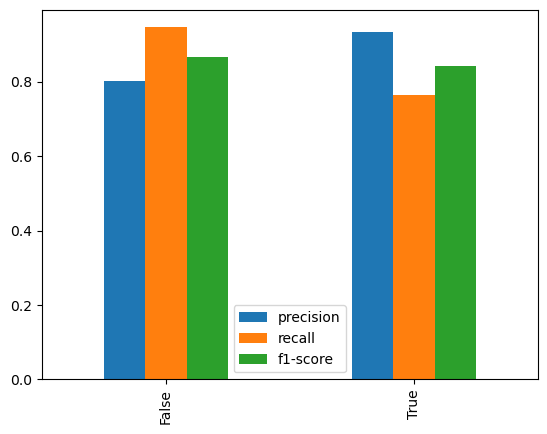

              precision    recall  f1-score   support

       False       0.81      0.87      0.84   1216105
        True       0.86      0.80      0.83   1215717

    accuracy                           0.83   2431822
   macro avg       0.84      0.83      0.83   2431822
weighted avg       0.84      0.83      0.83   2431822



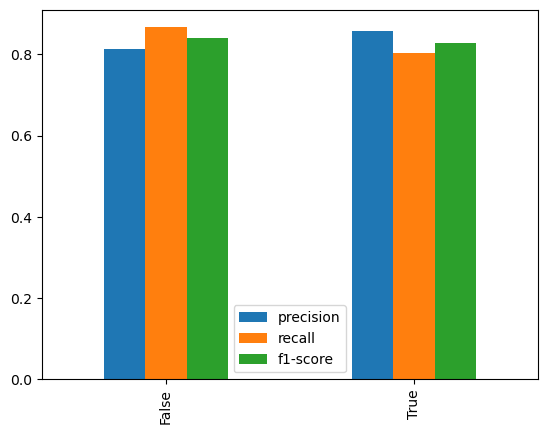

In [42]:
# Perform random over-sampling on dataset

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)
runModels(X_over, y_over, "Random Oversampling 1:1")

# ros2 = RandomOverSampler(random_state=0, sampling_strategy={1:368549})
# X_over2, y_over2 = ros2.fit_resample(X, y)
# runModels(X_over2, y_over2, "Random Oversampling 10:1")

# ros3 = RandomOverSampler(random_state=0, sampling_strategy={1:36855})
# X_over3, y_over3 = ros3.fit_resample(X, y)
# runModels(X_over3, y_over3, "Random Oversampling 100:1")

### SMOTE - Systematic Minority Oversampling

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, smote will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Systematic Majority Oversampling 1:1 data
Counter({False: 3684578, True: 3684578})
              precision    recall  f1-score   support

       False       0.84      0.96      0.90   1216105
        True       0.95      0.82      0.88   1215717

    accuracy                           0.89   2431822
   macro avg       0.90      0.89      0.89   2431822
weighted avg       0.90      0.89      0.89   2431822



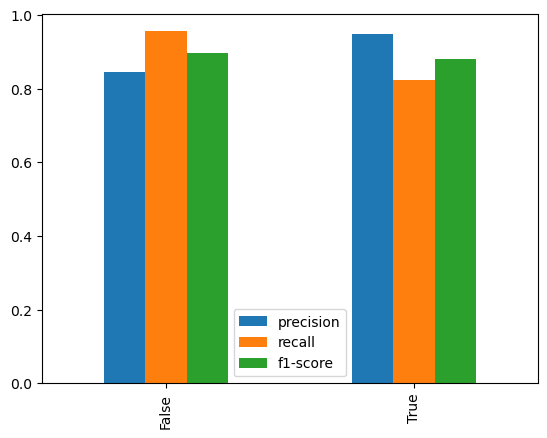

              precision    recall  f1-score   support

       False       0.85      0.86      0.85   1216105
        True       0.85      0.84      0.85   1215717

    accuracy                           0.85   2431822
   macro avg       0.85      0.85      0.85   2431822
weighted avg       0.85      0.85      0.85   2431822



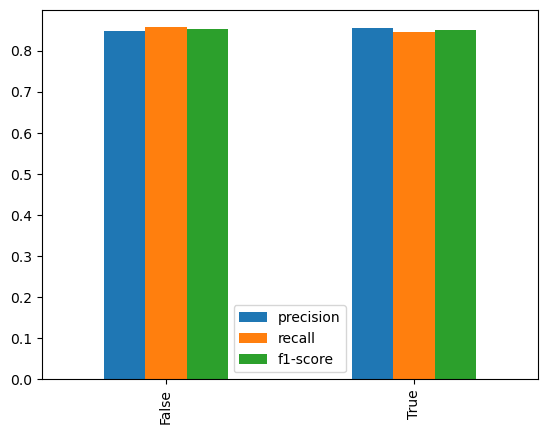

Performance metrics for Systematic Majority Oversampling 10:1 data
Counter({False: 3684578, True: 368549})
              precision    recall  f1-score   support

       False       0.98      0.96      0.97   1216387
        True       0.64      0.82      0.72    121145

    accuracy                           0.94   1337532
   macro avg       0.81      0.89      0.85   1337532
weighted avg       0.95      0.94      0.95   1337532



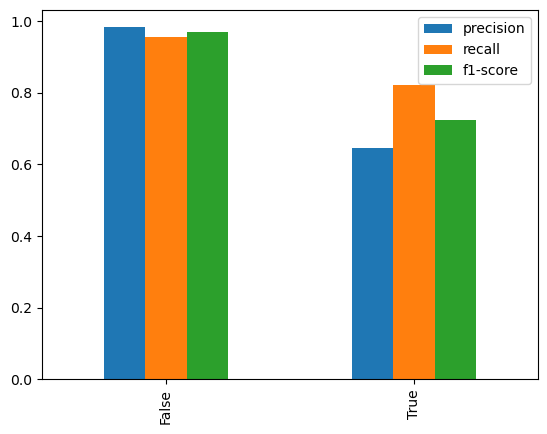

              precision    recall  f1-score   support

       False       0.97      0.97      0.97   1216387
        True       0.69      0.66      0.68    121145

    accuracy                           0.94   1337532
   macro avg       0.83      0.82      0.82   1337532
weighted avg       0.94      0.94      0.94   1337532



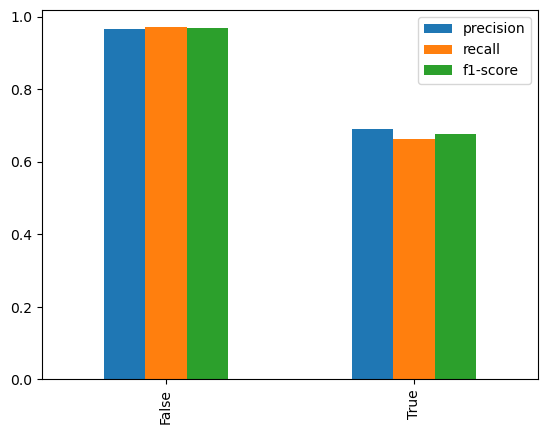

Performance metrics for Systematic Majority Oversampling 100:1 data
Counter({False: 3684578, True: 36855})
              precision    recall  f1-score   support

       False       1.00      0.95      0.97   1216026
        True       0.14      0.79      0.23     12047

    accuracy                           0.95   1228073
   macro avg       0.57      0.87      0.60   1228073
weighted avg       0.99      0.95      0.97   1228073



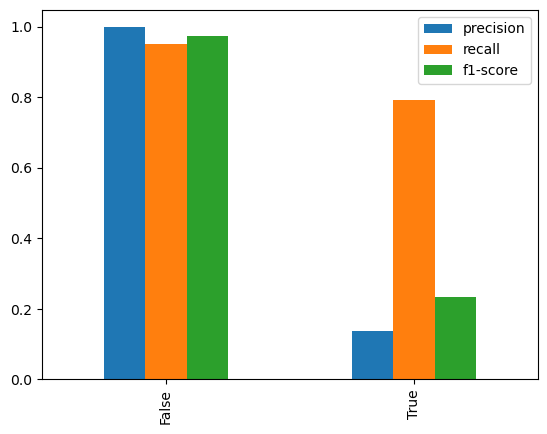

              precision    recall  f1-score   support

       False       1.00      0.98      0.99   1216026
        True       0.24      0.54      0.33     12047

    accuracy                           0.98   1228073
   macro avg       0.62      0.76      0.66   1228073
weighted avg       0.99      0.98      0.98   1228073



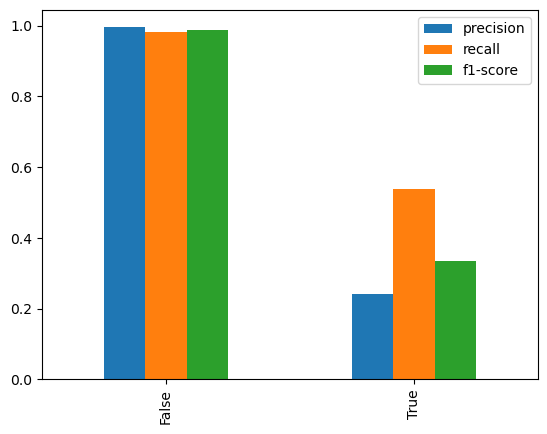

In [43]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
runModels(X_smote, y_smote, "Systematic Majority Oversampling 1:1")

smote2 = SMOTE(random_state=42, sampling_strategy={1:368549})
X_smote2, y_smote2 = smote2.fit_resample(X, y)
runModels(X_smote2, y_smote2, "Systematic Majority Oversampling 10:1")

smote3 = SMOTE(random_state=42, sampling_strategy={1:36855})
X_smote3, y_smote3  = smote3.fit_resample(X, y)
runModels(X_smote3, y_smote3, "Systematic Majority Oversampling 100:1")

### Random Undersampling

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset.

For this experiment, we will undersample the data in ratios 1:1, 10:1 and 100:1 Since the data was at ratio 368546:19302 majority class to minority class, random undersampling will scale down the number of datapoints for the majority class to match the above ratios.

Performance metrics for Random Undersampling 1:1 data
Counter({False: 19211, True: 19211})
              precision    recall  f1-score   support

       False       0.80      0.95      0.87      6369
        True       0.94      0.76      0.84      6311

    accuracy                           0.86     12680
   macro avg       0.87      0.86      0.85     12680
weighted avg       0.87      0.86      0.85     12680



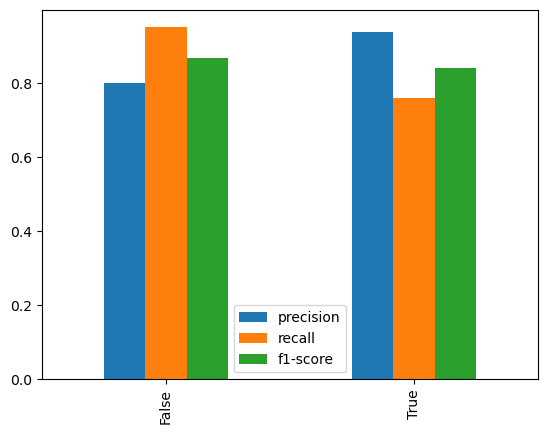

              precision    recall  f1-score   support

       False       0.80      0.87      0.83      6369
        True       0.86      0.78      0.82      6311

    accuracy                           0.83     12680
   macro avg       0.83      0.83      0.83     12680
weighted avg       0.83      0.83      0.83     12680



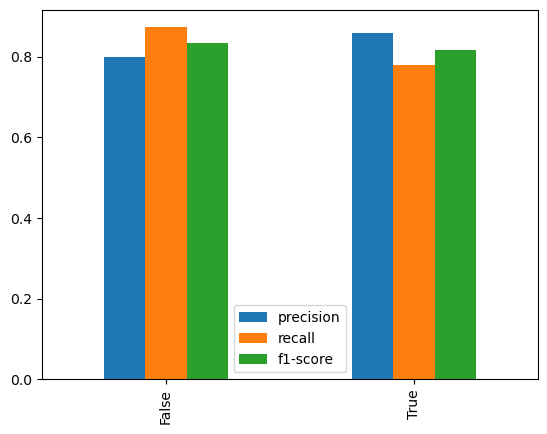

Performance metrics for Random Undersampling 10:1 data
Counter({False: 190000, True: 19000})
              precision    recall  f1-score   support

       False       0.98      0.94      0.96     62741
        True       0.58      0.76      0.66      6229

    accuracy                           0.93     68970
   macro avg       0.78      0.85      0.81     68970
weighted avg       0.94      0.93      0.93     68970



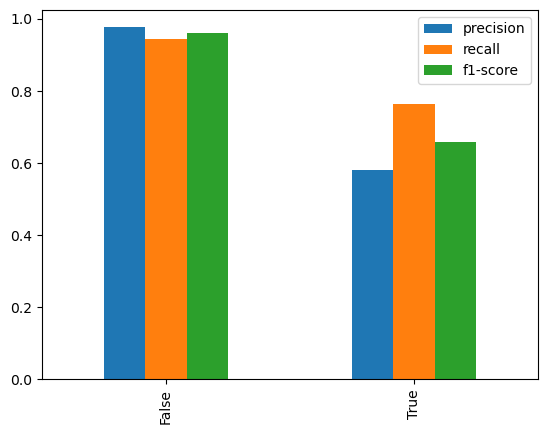

              precision    recall  f1-score   support

       False       0.96      0.97      0.97     62741
        True       0.68      0.61      0.64      6229

    accuracy                           0.94     68970
   macro avg       0.82      0.79      0.81     68970
weighted avg       0.94      0.94      0.94     68970



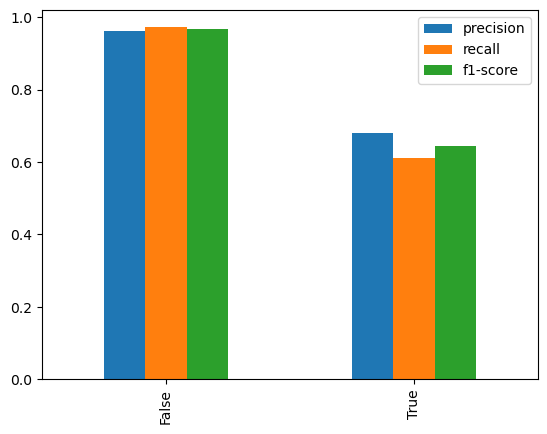

Performance metrics for Random Undersampling 100:1 data
Counter({False: 1900000, True: 19000})
              precision    recall  f1-score   support

       False       1.00      0.95      0.97    626997
        True       0.12      0.76      0.21      6273

    accuracy                           0.94    633270
   macro avg       0.56      0.85      0.59    633270
weighted avg       0.99      0.94      0.96    633270



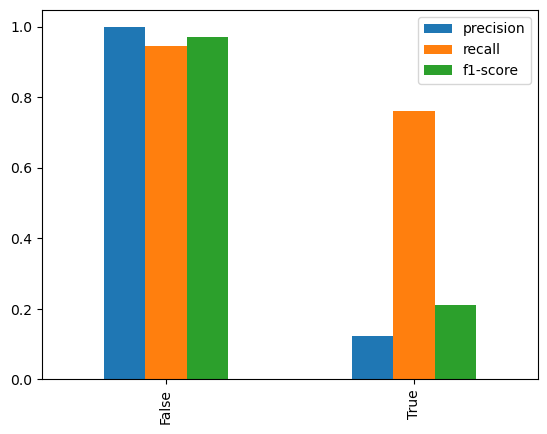

              precision    recall  f1-score   support

       False       1.00      0.98      0.99    626997
        True       0.25      0.53      0.34      6273

    accuracy                           0.98    633270
   macro avg       0.63      0.76      0.67    633270
weighted avg       0.99      0.98      0.98    633270



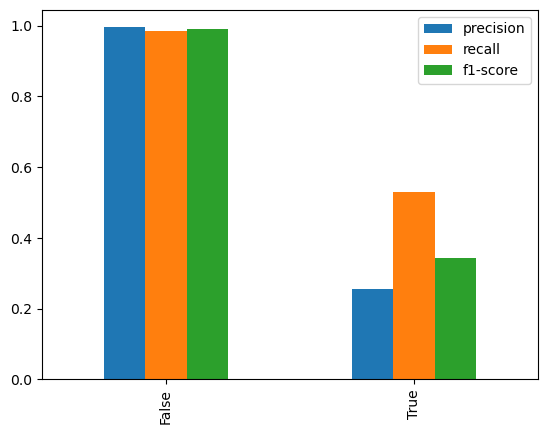

In [44]:
# Perform random under-sampling on dataset

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
runModels(X_under, y_under, "Random Undersampling 1:1")

rus2 = RandomUnderSampler(random_state=42, sampling_strategy={0:190000, 1:19000})
X_under2, y_under2 = rus2.fit_resample(X, y)
runModels(X_under2, y_under2, "Random Undersampling 10:1")

rus3 = RandomUnderSampler(random_state=42, sampling_strategy={0:1900000, 1:19000})
X_under3, y_under3 = rus3.fit_resample(X, y)
runModels(X_under3, y_under3, "Random Undersampling 100:1")